In [25]:
import os
import sys
import torch
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
from torchvision import transforms

sys.path.append(os.path.abspath(os.path.join("..")))

In [26]:
from src.models.autoencoder_all_losses import AELitModule

data_dir = "../data/FDP/"
sample_size = 8
ICSD_codes = os.listdir(data_dir)
chosen_codes = np.random.choice(ICSD_codes, sample_size)

run = "logs/train/runs/2023-08-09_13-45-39"  # SM-SSIM with 24 embed dims

In [27]:
epochs = [0, 49, 99, 149, 199, 249, 299]
epochs_fakes = []

transform = transforms.ToTensor()
structures = torch.stack(
    [
        transform(
            np.load(
                os.path.join(data_dir, ICSD_code, ICSD_code + "_structure.npy")
            ).astype(np.float32)
        )
        for ICSD_code in chosen_codes
    ]
)
patterns = torch.stack(
    [
        transform(
            np.clip(
                np.load(os.path.join(data_dir, ICSD_code, ICSD_code + "_+0+0+0.npy")),
                0,
                1,
            ).astype(np.float32)
        )
        for ICSD_code in chosen_codes
    ]
)

for epoch in epochs:
    epoch = str(epoch).zfill(3)
    litmodule = AELitModule.load_from_checkpoint(
        f"D:\\felix-ml\\{run}\\checkpoints\\epoch_{epoch}.ckpt"
    )
    fakes = litmodule.model(structures.cuda())
    fakes = fakes.view(sample_size * 128, 128).detach().cpu().numpy()
    epochs_fakes.append(fakes)

structures = structures.view(sample_size * 128, 128).detach().cpu().numpy()
patterns = patterns.view(sample_size * 128, 128).detach().cpu().numpy()

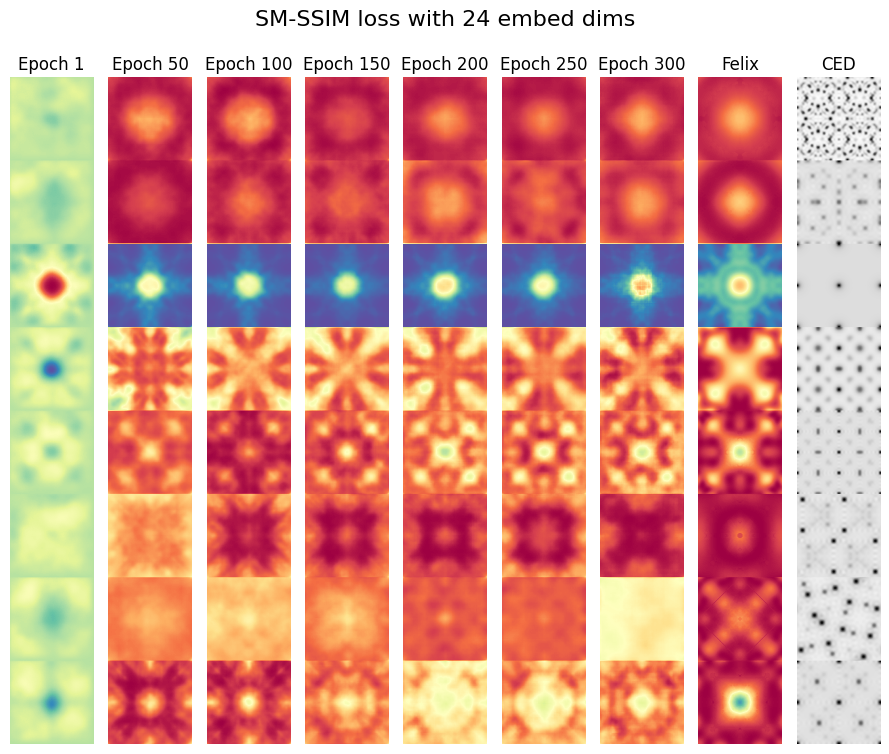

In [28]:
fig, axs = plt.subplots(ncols=len(epochs) + 2, figsize=(len(epochs) + 2, sample_size))
fig.suptitle("SM-SSIM loss with 24 embed dims", fontsize=16)

for i, epoch in enumerate(epochs):
    im = axs[i].imshow(epochs_fakes[i], cmap="Spectral")
    axs[i].set_title(f"Epoch {str(epoch + 1)}")

im1 = axs[-2].imshow(patterns, cmap="Spectral")
axs[-2].set_title("Felix")

im0 = axs[-1].imshow(structures, cmap="Greys")
axs[-1].set_title("CED")

for ax in axs:
    ax.axis("off")

plt.tight_layout()
plt.show()